In [2]:
import collections

import datasets
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import torch.optim as optim

In [3]:
dataset = datasets.load_dataset("zapsdcn/imdb", cache_dir="../data/classification/")

The loaded `dataset` is already split into training, validation and testing sets. Looking at the outputs, we can see the number of examples (`num_rows`) in each split and three features named `id`, `text` and `label`.

In [4]:
train_dataset = dataset['train'] 
validation_dataset = dataset['validation']
test_dataset = dataset['test']

train_dataset, validation_dataset, test_dataset

(Dataset({
     features: ['id', 'text', 'label'],
     num_rows: 20000
 }),
 Dataset({
     features: ['id', 'text', 'label'],
     num_rows: 5000
 }),
 Dataset({
     features: ['id', 'text', 'label'],
     num_rows: 25000
 }))

Looking at one such training example, we can see that 
- `id` contains information related to some index. Don't bother too much about this as this is not relevant for the application at hand.
- `text` is where we have the actual review!
- `label` denotes whether it's a good (if 1) or bad (if 0) review! 

In [5]:
train_dataset[-3]

{'id': 'train_10348',
 'text': 'This movie is very good. The screenplay is enchanting. But Meryl Streep is most impressive. Her performance is excellent. She brings me to go into the heart of her role.',
 'label': 1}

## Tokenization and Vocabulary Building

In [6]:
from transformers import AutoTokenizer

# Initialize a Hugging Face tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")  # You can choose any Hugging Face model

# Example of tokenizing a text using Hugging Face tokenizer
sample_text = train_dataset[3]['text']
tokenized_output = tokenizer(sample_text, padding=True, truncation=True, return_tensors="pt")

print(tokenized_output)


{'input_ids': tensor([[  101,  2009,  1005,  1055,  2107,  1037,  9467,  2008,  2138,  1997,
          2009,  1005,  1055,  2516,  2023,  2143,  2097,  2022,  9511,  2011,
          2111,  2040,  5223,  2374,  1012,  8815,  2009,  2066, 10272,  3511,
          2003,  2172,  2062,  2084,  1037, 18178,  2229,  2100,  2998, 17312,
          1012,  1996,  2466,  2240,  2003,  7244,  1998,  9414,  2302,  2108,
          2061, 27659,  1010,  1996, 13198,  2020,  4756,  2041,  5189,  6057,
          1010,  1998,  1996,  3494,  2024,  2092,  6051,  1012, 11968, 23356,
          2121,  6583, 17643,  1998, 26679,  2527,  5000,  3051,  2024,  8235,
          2004, 12908, 12245,  1998, 11044,  1010,  5128,  1999,  2307,  4616,
          2119,  2006,  1998,  2125,  1996,  6510,  1012,  2019,  6279,  3286,
          1047,  5886,  2003,  6919,  2004, 12245,  1005,  5191,  2269,  1010,
          1998,  5655, 13919,  1011, 11527,  2015,  1010,  2040,  2001,  2061,
         29350,  4763,  1999,  1005,  

In [7]:
def tokenize(example, tokenizer, max_length):
    tokens = tokenizer(example["text"])[:max_length]
    return {"tokens": tokens}

In [8]:
# Define the maximum sequence length
max_length = 512

# Function to tokenize the dataset using the Hugging Face tokenizer
def tokenize(batch, tokenizer, max_length):
    return tokenizer(
        batch['text'],  # Text field in the dataset
        padding="max_length",  # Pad to max_length
        truncation=True,       # Truncate to max_length
        max_length=max_length, # Set maximum length
        return_tensors="pt"    # Return PyTorch tensors
    )

# Apply the tokenization to train, validation, and test datasets
train_dataset = train_dataset.map(
    lambda batch: tokenize(batch, tokenizer=tokenizer, max_length=max_length),
    batched=True
)
validation_dataset = validation_dataset.map(
    lambda batch: tokenize(batch, tokenizer=tokenizer, max_length=max_length),
    batched=True
)
test_dataset = test_dataset.map(
    lambda batch: tokenize(batch, tokenizer=tokenizer, max_length=max_length),
    batched=True
)


Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Let's build a volcabulary out of these tokens.

In [9]:
train_dataset

Dataset({
    features: ['id', 'text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 20000
})

In [10]:
# Special tokens are automatically handled by Hugging Face tokenizers
special_tokens = ["[UNK]", "[PAD]"]  # These are typical for models like BERT

# Ensure the tokenizer uses the correct special tokens
tokenizer.add_special_tokens({
    "unk_token": special_tokens[0],
    "pad_token": special_tokens[1],
})

# Hugging Face tokenizers have a pre-built vocabulary, so we directly access it
vocab = tokenizer.get_vocab()

# Example: Print the vocabulary size
print(f"Vocabulary size: {len(vocab)}")


Vocabulary size: 30522


In [11]:
print("Vocab Size: ", len(vocab))

Vocab Size:  30522


Making sure that words that are not in the vocabulary gets mapped to `"<unk>"` and assiging a token for padding as well (we'll cover padding later).

In [12]:
# Access indices for special tokens directly from the tokenizer
unk_index = tokenizer.unk_token_id  # ID for [UNK]
pad_index = tokenizer.pad_token_id  # ID for [PAD]

# Example: Test accessing a token that is not in the vocabulary
test_token = "some_token_that_is_not_in_vocab"
token_id = tokenizer.convert_tokens_to_ids(test_token)

print(f"Token: {test_token}")
print(f"Token ID: {token_id}")
print(f"Unknown token ID: {unk_index}")
print(f"Padding token ID: {pad_index}")


Token: some_token_that_is_not_in_vocab
Token ID: 100
Unknown token ID: 100
Padding token ID: 0


In [13]:
tokens = tokenizer(train_dataset[-3]["text"])["input_ids"]
print(tokens)


[101, 2023, 3185, 2003, 2200, 2204, 1012, 1996, 9000, 2003, 4372, 14856, 3436, 1012, 2021, 21442, 8516, 2358, 9910, 2361, 2003, 2087, 8052, 1012, 2014, 2836, 2003, 6581, 1012, 2016, 7545, 2033, 2000, 2175, 2046, 1996, 2540, 1997, 2014, 2535, 1012, 102]


Let's do this in a more refined way for all of the datasets and store these number in the `id` feature!

In [16]:
def numericalize(example, vocab):
    id = vocab.lookup_indices(example["tokens"])
    return {"id": id}

In [17]:
# Define a preprocessing function for tokenization
def preprocess_function(batch):
    return tokenizer(
        batch["text"],  # Replace "text" with the actual text field in your dataset
        padding="max_length",
        truncation=True,
        max_length=512,
        return_tensors="pt",
    )

# Apply tokenization to datasets
train_dataset = train_dataset.map(preprocess_function, batched=True)
validation_dataset = validation_dataset.map(preprocess_function, batched=True)
test_dataset = test_dataset.map(preprocess_function, batched=True)

# Format datasets for PyTorch DataLoader
train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
validation_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

# Define a custom collate function for batching
def collate_fn(batch):
    # Convert batch (list of dicts) into a dict of tensors
    batch_dict = {key: [d[key] for d in batch] for key in batch[0].keys()}

    for key in batch_dict.keys():
        if key in ["input_ids", "attention_mask"]:  # Fields that need padding
            batch_dict[key] = torch.nn.utils.rnn.pad_sequence(
                batch_dict[key],
                batch_first=True,
                padding_value=tokenizer.pad_token_id,
            )
        elif key == "label":  # Labels should be stacked
            batch_dict[key] = torch.tensor(batch_dict[key], dtype=torch.long)
        else:
            raise ValueError(f"Unexpected field '{key}' in batch.")

    return batch_dict

# Function to create DataLoader
def get_data_loader(dataset, batch_size, shuffle=False):
    return torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        collate_fn=collate_fn,
        shuffle=shuffle,
    )

# Batch size
batch_size = 512

# Create DataLoaders for train, validation, and test datasets
train_data_loader = get_data_loader(train_dataset, batch_size, shuffle=True)
validation_data_loader = get_data_loader(validation_dataset, batch_size)
test_data_loader = get_data_loader(test_dataset, batch_size)


Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

In [18]:
class SelfAttention(torch.nn.Module):
    def __init__(self, emb, heads):
        super().__init__()
        assert emb % heads == 0
        self.emb, self.heads = emb, heads

        # Three emb x emb matrix multiplications to get queries, keys and values
        self.to_queries = torch.nn.Linear(emb, emb)
        self.to_keys = torch.nn.Linear(emb, emb)
        self.to_values = torch.nn.Linear(emb, emb)

        # One last Linear layer at the end with emb x emb matrix multiplication
        self.unify = torch.nn.Linear(emb, emb)

    def forward(self, x):
        b, t, emb = x.shape # Batch Size, Sequence Length, embedding dim
        h = self.heads

        # Computing queries, keys and values
        queries = self.to_queries(x)
        keys = self.to_keys(x)
        values = self.to_values(x)

        # Slicing out the heads
        queries = queries.view(b, t, h, emb//h)
        keys = keys.view(b, t, h, emb//h)
        values = values.view(b, t, h, emb//h)

        # Folding heads into batch dims (Remember head computations can run in parallel)
        queries = queries.transpose(1, 2).reshape(b*h, t, emb//h)
        keys = keys.transpose(1, 2).reshape(b*h, t, emb//h)
        values = values.transpose(1, 2).reshape(b*h, t, emb//h)

        # Here comes Self Attention...
        W = torch.bmm(queries, keys.transpose(1,2)) # Computing Weights
        W = W / (emb**(1/2)) # Scaling for stability
        W = F.softmax(W, dim=2) # Row-wise Softmax
        y = torch.bmm(W, values).view(b, h, t, emb//h) # Computing y
        y = y.transpose(1, 2).reshape(b, t, emb) # Concatenating heads

        # Final Linear NN Layer
        return self.unify(y), W

## Transformer Block

In [19]:
class TransformerBlock(torch.nn.Module):
    def __init__(self, emb, heads):
        super().__init__()

        # Attention Block
        self.attention = SelfAttention(emb, heads)

        # Layer Normalizations
        self.norm1 = torch.nn.LayerNorm(emb)
        self.norm2 = torch.nn.LayerNorm(emb)

        # FCN
        self.fcn = torch.nn.Sequential(
            torch.nn.Linear(emb, 4*emb),
            torch.nn.ReLU(),
            torch.nn.Linear(4*emb, emb)
        )

    def forward(self, x):
        attented, W = self.attention(x)
        x = self.norm1(attented + x)
        ff = self.fcn(x)
        
        return self.norm2(ff + x), W

## Transformer Neural Network

In [20]:
class Transformer(torch.nn.Module):
    def __init__(self, emb, heads, max_seq_length, vocab_size):
        super().__init__()
        self.vocab_size = vocab_size

        self.token_embedding = torch.nn.Embedding(embedding_dim=emb, num_embeddings=vocab_size)
        self.pos_embedding = torch.nn.Embedding(embedding_dim=emb, num_embeddings=max_seq_length)

        self.tblock = TransformerBlock(emb=emb, heads=heads)

        self.toprobs = torch.nn.Linear(emb, 2)

    def forward(self, x):
        tokens = self.token_embedding(x)
        b, t, e = tokens.shape
        
        positions = self.pos_embedding(torch.arange(t, device="cuda"))[None, :, :].expand(b, t, e)
        x = tokens + positions

        x, W = self.tblock(x)
        x = torch.mean(x, dim=1)
        x = self.toprobs(x)

        return F.log_softmax(x, dim=1), W

In [21]:
for batch in train_data_loader:
    print(batch.keys())
    break


dict_keys(['label', 'input_ids', 'attention_mask'])


In [22]:
lr = 0.001
num_epochs = 20
heads = 4

model = Transformer(emb=32, heads=heads, max_seq_length=max_length, vocab_size=len(vocab)).to("cuda")

opt = torch.optim.Adam(lr=lr, params=model.parameters())

In [ ]:
accs = []  # List to store validation accuracies

for epoch in range(num_epochs):  # Loop over epochs
    model.train()  # Set model to training mode
    epoch_loss = 0.0

    # Training loop
    for batch in tqdm(train_data_loader, desc=f"Epoch {epoch + 1}/{num_epochs} - Training"):
        opt.zero_grad()  # Clear gradients for the optimizer

        # Move data to GPU
        input = batch["input_ids"].to("cuda")  # Use input_ids as the input
        output = batch["label"].to("cuda")    # Use label as the target

        # Truncate inputs if necessary
        if input.shape[1] > max_length:
            input = input[:, :max_length]

        # Forward pass and compute loss
        preds, _ = model(input)
        loss = F.cross_entropy(preds, output)  # Use cross-entropy for raw logits

        # Backward pass and update
        loss.backward()
        opt.step()

        # Accumulate loss
        epoch_loss += loss.item()

    # Validation loop
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        tot, cor = 0.0, 0.0
        for batch in tqdm(validation_data_loader, desc="Validation"):
            # Move data to GPU
            input = batch["input_ids"].to("cuda")  # Use input_ids as the input
            output = batch["label"].to("cuda")    # Use label as the target

            # Truncate inputs if necessary
            if input.shape[1] > max_length:
                input = input[:, :max_length]

            # Forward pass
            preds, _ = model(input)
            preds = preds.argmax(dim=1)  # Get predicted class indices

            # Calculate metrics
            tot += float(input.size(0))
            cor += float((output == preds).sum().item())

        acc = cor / tot  # Calculate validation accuracy
        accs.append(acc)  # Store validation accuracy

    # Log epoch metrics
    print(f"Epoch {epoch + 1}/{num_epochs}; Loss: {epoch_loss:.4f}; Validation Accuracy: {acc:.4f}")

# Save model and accuracies
torch.save(model.state_dict(), f"trained_models/classify_{heads}heads.pt")
np.save("trained_models/acc.npy", accs)


In [ ]:
# Plot Validation Accuracy
accs = np.load("trained_models/acc.npy")
plt.style.use('default')
plt.plot(np.linspace(0, 20, len(accs)), accs, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.ylim(0.45, 1)
plt.grid()
plt.title("Transformer Neural Network")
plt.legend()
plt.show()

## Testing

In [24]:
# Load model with heads. Options: {1 or 4}
heads = 4 

# Loading Model
model.load_state_dict(torch.load("./trained_models/classify_{}heads.pt".format(heads), weights_only=True))

<All keys matched successfully>

In [25]:
acc = 0  # Initialize accuracy

with torch.no_grad():  # Disable gradient computation
    tot, cor = 0.0, 0.0  # Initialize total and correct counters
    for batch in validation_data_loader:
        # Use the correct keys for input and label
        input = batch["input_ids"].to("cuda")  # Use input_ids as the input
        output = batch["label"].to("cuda")    # Use label as the target

        # Truncate inputs if necessary
        if input.shape[1] > max_length:
            input = input[:, :max_length]

        # Forward pass
        preds, _ = model(input)
        preds = preds.argmax(dim=1)  # Get predicted class indices

        # Update metrics
        tot += float(input.size(0))
        cor += float((output == preds).sum().item())

    acc = cor / tot  # Calculate accuracy

print("Testing Accuracy: ", acc)


Testing Accuracy:  0.8542


In [26]:
# Picking a random testing review
test_review = next(iter(test_data_loader))["input_ids"][0]

# Printing the first 10 tokens of the review
text = []
for num in test_review.numpy()[:10]:  # Extract the first 10 token IDs
    token = tokenizer.convert_ids_to_tokens([num])[0]  # Convert ID to token
    text.append(token)
    print(token)


[CLS]
i
went
and
saw
this
movie
last
night
after


In [27]:
test_review.unsqueeze(0).shape

torch.Size([1, 512])

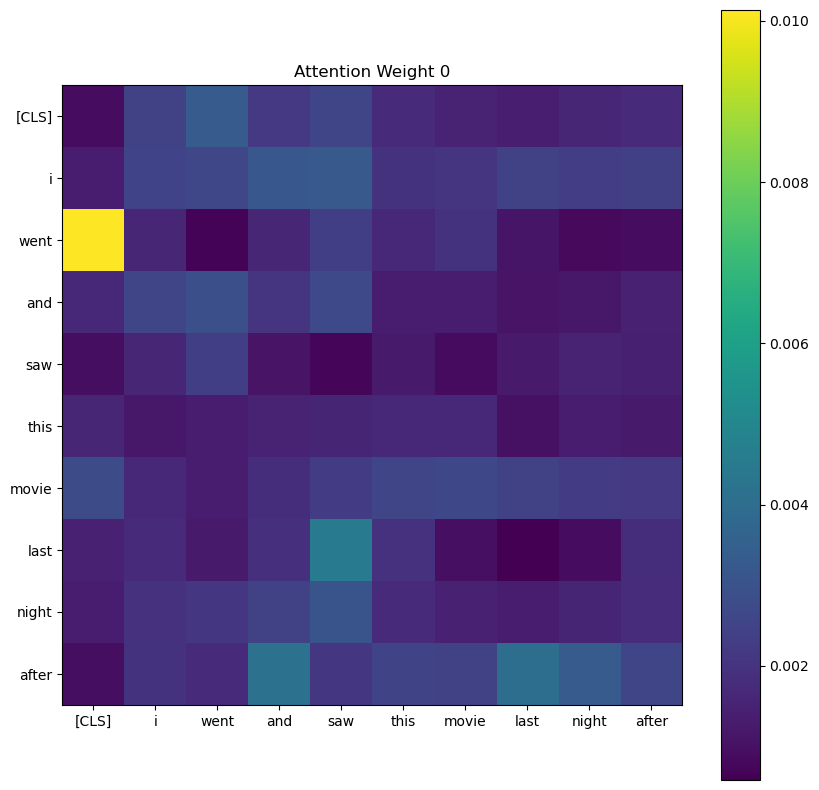

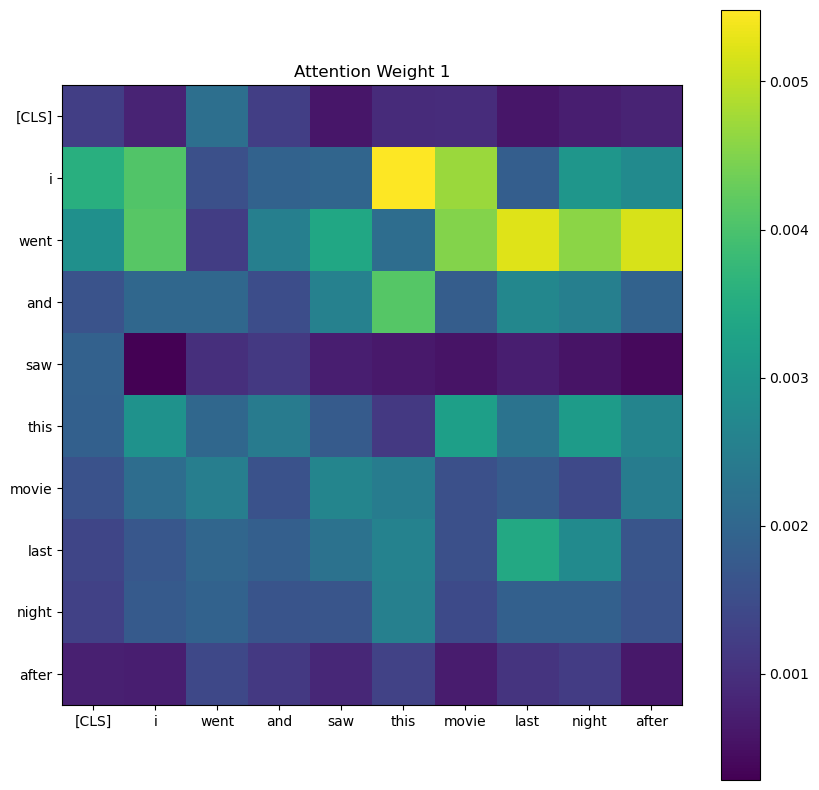

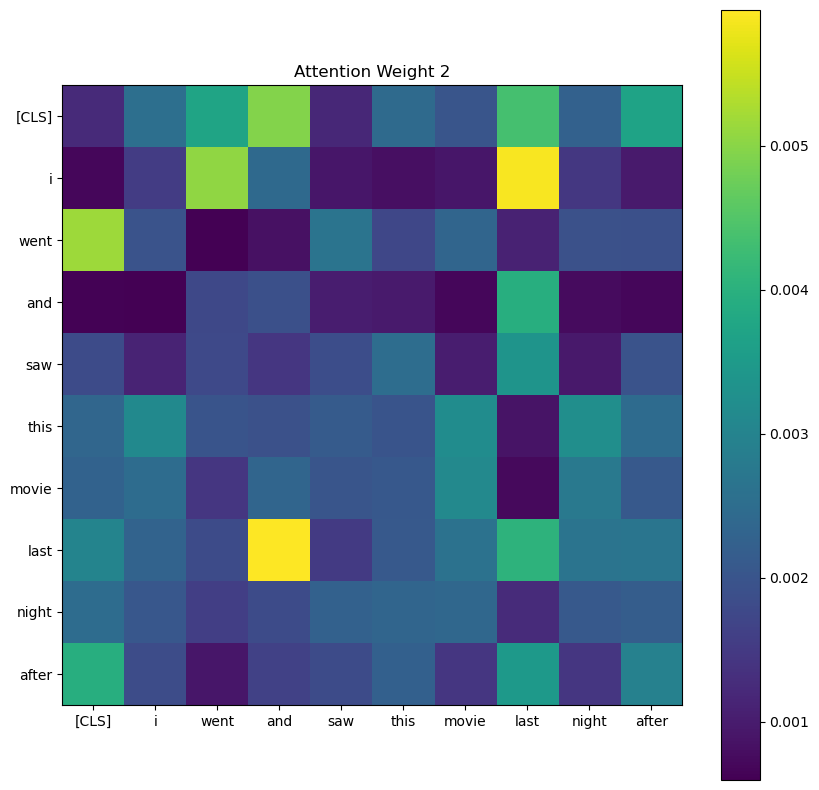

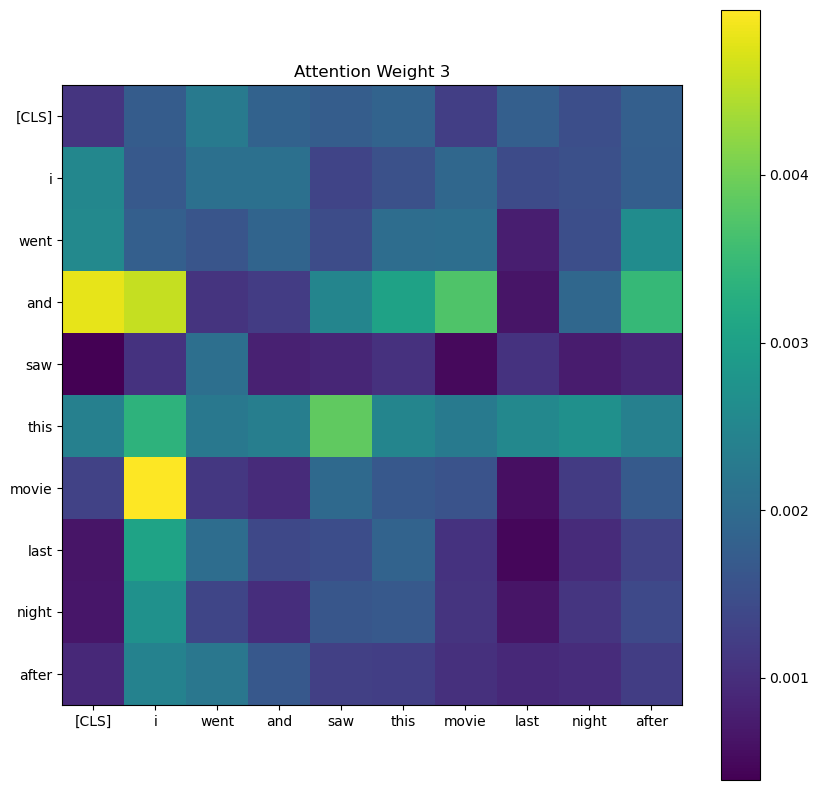

In [28]:
with torch.no_grad():
    _, attention = model(test_review.unsqueeze(0).to("cuda"))

    attention_weights = attention.cpu().numpy()
    
for (i, attention) in enumerate(attention_weights):
    plt.style.use('default')
    plt.figure(figsize=(10,10))
    plt.imshow(attention[:10, :10]) 
    plt.xticks(np.arange(0, 10), text[:10])
    plt.yticks(np.arange(0, 10), text[:10])
    plt.colorbar()
    plt.title("Attention Weight {}".format(i))
    plt.show()
